In [1]:
import os
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#Keras
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, Model, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
#sklearn helpers
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


##Citation:

```
@article{rajaraman2018pre,
  title={Pre-trained convolutional neural networks as feature extractors toward
  improved malaria parasite detection in thin blood smear images},
  author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
  and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger,
  Stefan and Thoma, George R},
  journal={PeerJ},
  volume={6},
  pages={e4568},
  year={2018},
  publisher={PeerJ Inc.}}
```

In [2]:
#Download the file and save it in a temporary placeholder '/tmp'
!wget --no-check-certificate \
   ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip -O /tmp/cell_images.zip


--2020-02-02 17:24:06--  ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
           => ‘/tmp/cell_images.zip’
Resolving lhcftp.nlm.nih.gov (lhcftp.nlm.nih.gov)... 130.14.55.35, 2607:f220:41e:7055::35
Connecting to lhcftp.nlm.nih.gov (lhcftp.nlm.nih.gov)|130.14.55.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Open-Access-Datasets/Malaria ... done.
==> SIZE cell_images.zip ... 353452851
==> PASV ... done.    ==> RETR cell_images.zip ... done.
Length: 353452851 (337M) (unauthoritative)

cell_images.zip     100%[===================>] 337.08M  40.5MB/s    in 8.5s    

2020-02-02 17:24:17 (39.9 MB/s) - ‘/tmp/cell_images.zip’ saved [353452851]



In [0]:
#Unzip the file in '/tmp'
local_zip = '/tmp/cell_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
ls '/tmp/cell_images'

Parasitized/  Uninfected/


In [5]:
par_dir = os.path.join('/tmp/cell_images/Parasitized')
healthy_dir = os.path.join('/tmp/cell_images/Uninfected')

print('total Parasitized images:', len(os.listdir(par_dir)))
print('total healthy images:', len(os.listdir(healthy_dir)))

par_files = os.listdir(par_dir)
print(par_files[:5])

healthy_files = os.listdir(healthy_dir)
print(healthy_files[:5])

total Parasitized images: 13780
total healthy images: 13780
['C57P18thinF_IMG_20150729_111518_cell_253.png', 'C59P20thinF_IMG_20150803_115303_cell_42.png', 'C80P41ThinF_IMG_20150817_111802_cell_12.png', 'C48P9thinF_IMG_20150721_160406_cell_244.png', 'C68P29N_ThinF_IMG_20150819_134326_cell_118.png']
['C138P99ThinF_IMG_20151005_173453_cell_102.png', 'C64P25N_ThinF_IMG_20150818_152455_cell_18.png', 'C233ThinF_IMG_20151112_160635_cell_237.png', 'C121P82ThinF_IMG_20151002_133739_cell_1.png', 'C233ThinF_IMG_20151112_161024_cell_248.png']


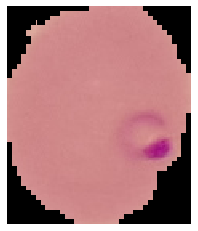

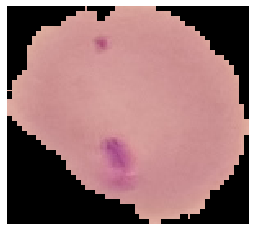

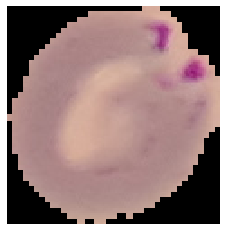

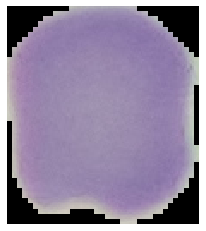

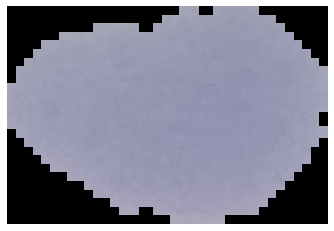

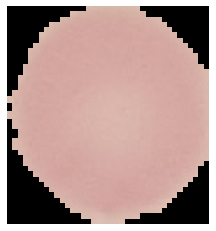

In [6]:
INDEX = 10

#a sample of images with parasite
sample_par = [os.path.join(par_dir, fname) for fname in par_files[INDEX -3:INDEX ]]
#a sample of images labeled as healthy
sample_healthy = [os.path.join(healthy_dir, fname) for fname in healthy_files[INDEX -3:INDEX ]]

sample = sample_par + sample_healthy

for img_path in sample:
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

Setting up the hyperparameters:

Note that the images have different widths and heights. So we choose a predetermined set of width and hieght parameters which we pass to the
```ImageDataGenerator``` (see the cell below).

In [0]:
LR = 0.001
BATCH_SIZE = 64
NEPOCHS = 15
IMG_WIDTH, IMG_HEIGHT = 128, 128
VALIDATION_RATIO = 0.2

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip=True,
    validation_split=VALIDATION_RATIO) # set validation split

train_generator = train_datagen.flow_from_directory(
    "/tmp/cell_images/",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    "/tmp/cell_images/", 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation') 

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [0]:
def make_model():
    model = models.Sequential([
      # The input shape is size of the image from the data generator IMG_WIDTHxIMG_HEIGHT with 3 channel color
      layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
      layers.MaxPooling2D(2, 2),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(512, activation='relu'),
      layers.Dense(1, activation='sigmoid')])
    
    return model

In [10]:
malaria_model = make_model()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
malaria_model.summary()

malaria_model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr = LR), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)      

In [0]:
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [0]:
history = malaria_model.fit_generator(train_generator, 
                                      epochs=NEPOCHS, 
                                      validation_data = validation_generator, 
                                      callbacks=[early_stopping],
                                      verbose = 1)




Epoch 1/15





 84/345 [======>.......................] - ETA: 1:23 - loss: 0.6527 - acc: 0.6187

In [0]:
def plot_history(h):
 
 h = h.history
 fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
 ax[0].plot(h["loss"], linewidth = 2, label = "training")
 ax[0].plot(h["val_loss"], linewidth = 2, label = "dev")
 ax[1].plot(h["acc"], linewidth = 2, label = "training")
 ax[1].plot(h["val_acc"], linewidth = 2, label = "dev")
 ax[0].set_ylabel("Loss")
 ax[1].set_ylabel("Accuracy")
 ax[0].set_xlabel("EPOCH")
 ax[1].set_xlabel("EPOCH")
 ax[0].legend(fontsize = 10)
 ax[1].legend(fontsize = 10)

 return None

In [0]:
plot_history(history)

In [0]:
generator = train_datagen.flow_from_directory(
        "/tmp/cell_images/",
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode=None,  # only data, no labels
        shuffle=False)  # keep data in same order as labels

In [0]:
true_labels = generator.labels
probs = malaria_model.predict_generator(generator)
pred_labels = probs.flatten()
pred_labels[pred_labels > 0.5] = 1
pred_labels[pred_labels < 0.5] = 0
confusion_matrix(true_labels, pred_labels)